# EWI modeling

Our objective in this work is to predict a level of risk of seeing HIV resistance appear in an HIV cohort, based on routine data observed in this cohort. To do so, we can rely on Early Warning Indicators surveys conducted by the DRC HIV program. The EWI are a set of proxy measures of factors associated with the development of HIV drug resistance. There is little evidence or quantification of how much EWI can actually predict HIVDR.

In this notebook, we present our data modeling strategy and results for the modeling of EWI on routine data.

In [1]:
#Library loads

import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for more advanced plotting function
import numpy as np # for numerical functions
import math # for select math functions

# Different models and modeling tools
import sklearn.linear_model as lm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter('ignore')

## Data Load and Description

We load 2 main data sets : 
* Covariates are a set of data elements from HIVDR that have been identified as being potentially correlated with EWI
* IAP are the EWI data collected by DRC's PNLS

We also have defined two helper references to structure our data
* HIVDR data elements mapping is a tagging of HIVDR data elements on 3 dimensions (population, action, sub population), that allows us to match similar data elements from Cordaid and SNIS data sources, and to filter data elements based on our interest.
* IAP matched is a matching between the name and identifiers of Health Facilities between the HIVDR data and the EWI data. 

In [2]:
# Loading HIVDR data and tagging reference as well as IAP to HIVDR health facilities matching
iap_covariates = pd.read_csv("../data/processed/iap_covariates.csv")
hivdr_de = pd.read_csv("../data/processed/hivdr_de_mapping.csv", sep=';')
iap_matched = pd.read_csv("../data/processed/iap_fosa_matched.csv")
iap_matched = iap_matched.dropna()

# Merging covariates with their tagging
labelled_covariates = iap_covariates.merge(hivdr_de)

# Merging covariates with health facilities matching to only keep relevant health facilities
full_data = labelled_covariates.merge(iap_matched, left_on = "uidorgunit", right_on = "fosa_id")
full_data = full_data[['monthly', 'quarterly', 'dataelementname', 'catcomboname','population', 
                       'action', 'sub_population', 'province', 'fosa','value']]


# Loading EWI data
iap_data = pd.read_excel("../data/IAP_RDC_2010_2016_final.xlsx", sheet_name = "2010_2016")
iap_data = iap_data.dropna(subset=["% Rétention à 12 mois des patients sous TAR de 1ère ligne (cible ≥ 70%)2010-2012/(cible ≥ 90%) 2016"])

### Preparing HIVDR Data

We want to do to things to HIVDR data elements to make them ready for use in modeling. 
* First we want to combine different data element combos for each data element.
* Second, we want to impute missing zeros based on the existence of at least one data value for a given report on a given date. 

In [3]:
def make_sum(data):
    if data.value.iloc[0] in ["true", "false"]:
        out = pd.DataFrame.from_dict({"value":[data.value.iloc[0]]})
    else :
        data.value = data.value.astype(float)
        out = pd.DataFrame.from_dict({"value":[data.value.sum()]})
    return out


def impute_zero_dataelementname(df):
    """ This function is used to populate a pandas dfs with rows for each data element and zero imputed value
    where at least one value for fosa x period x data element exists in the data.
        
    :param df: This is a pandas df that has rows only for manually inputed data element.
        
    :return: out: This function returns a pandas df augmented with extra rows for every existing data element.
    """
    import pandas as pd    
    out = []
        
    list_fosa = df.fosa.unique()
        
    for fosa in list_fosa:
        sub_df = df[df.fosa == fosa]
        # first, drop duplicates in month x data element, then create a contigency table month x dataelement
        sub_df_piv = sub_df.drop_duplicates(subset=["monthly","dataelementname"], keep='last').pivot(index="monthly", columns="dataelementname", values=["value"])
        # second, stacked the values to go back to a df format with one row per month and data element
        # we replace NAs by 0, as we think that if a report was filled out, the missing values are really zeros
        sub_df_piv_stacked = sub_df_piv.fillna(0).stack()
        sub_df_piv_stacked = pd.DataFrame(sub_df_piv_stacked)
        sub_df_piv_stacked = sub_df_piv_stacked.reset_index()
        # finally, we merged it back with the original data frame
        new_df = sub_df.merge(sub_df_piv_stacked, how = 'outer')        
        out.append(new_df)
    # return the transformed data frame
    df_augmented = pd.concat(out)
    return(df_augmented)


full_data = full_data.groupby(["province","fosa","monthly","quarterly", "population","action","sub_population","dataelementname"]).apply(make_sum)
full_data = full_data.reset_index().drop("level_8", 1)
full_data["standard_de"] = full_data["population"] + "_" + full_data["action"]  + "_" + full_data["sub_population"]
full_data_imp = impute_zero_dataelementname(full_data)

For tractability of the model, we only keep in a first movement a subset of the variables in the covariates, and we then build ad-hoc covariates for our results.

In [4]:
useful_variables = full_data[~(full_data.population == "vih_positive") &  
                             ~(full_data.action.str.contains("tb|cv|_ist|dead|cotrim|nut|treatment_supplement|no_treatment_response|counciled_tested")) &
                             ~(full_data.sub_population.str.contains("soutien"))]

#### Variable 1 : Number of patients in First and second line of treatment

We create a variables that combines the different treatment lines, and counts the number of patients in first and second line.

In [5]:
treat_scheme = ["azt_3tc_lpv_r","tdf_ftc_nvp","abc_3tc_nvp","abc_3tc_efv","azt_3tc_efv","tdf_3tc_efv",
                "tdf_3tc_nvp","tdf_3tc_lpv_r","tdf_ftc_efv","azt_3tc_nvp","abc_3tc_lpv_r","tdf_ftc_lpv_r"]

treatments = useful_variables[useful_variables.sub_population.isin(treat_scheme)]
treatments_fu = treatments.groupby(["province","fosa","monthly","sub_population"]).value.sum().reset_index()
treatments_fu["line"] = 'first_line'
treatments_fu.loc[treatments_fu.sub_population.str.contains("lpv"),"line"] = "second_line"
line_fu = treatments_fu.groupby(["province","fosa","line"]).value.mean().reset_index()
line_fu = line_fu.set_index(["province","fosa"]).pivot(columns = "line")["value"].reset_index()

#### Variable 2 : Number of LTFU Patients

In [6]:
pdv_data = useful_variables[(useful_variables.action == "pdv")]
pdv_data.value = pd.to_numeric(pdv_data.value)
pdv_data = pdv_data.groupby(["province","fosa"]).value.mean().reset_index()
pdv_data.columns = ["province", "fosa", "n_pdv"]

#### Variable 3 : Total number of patients on treatment

In [7]:
pvvih_data = useful_variables[(useful_variables.population == "pvvih") & (useful_variables.action == "enrolled_hiv_services")]
pvvih_data.value = pd.to_numeric(pvvih_data.value)
pvvih_data = pvvih_data.groupby(["province","fosa"]).value.mean().reset_index()
pvvih_data.columns = ["province", "fosa", "n_pvvih"]

#### Variable 4 : Percentage of months with stockouts

In [8]:
stock_out_data = useful_variables[useful_variables.action == "rupture_stock_mois"]
def stock_out_prob(data):    
    return sum(data == "true") / len(data)


stock_out_data = stock_out_data.groupby(["province","fosa"]).value.apply(stock_out_prob).reset_index()
stock_out_data.columns = ["province", "fosa", "stockout_perc"]

#### Variable 5 : Average Monthly ART consumption

In [9]:
cmm_data = useful_variables[useful_variables.action == "cmm_mois"]

cmm_data = cmm_data.groupby(["province","fosa","monthly"]).value.sum().reset_index().groupby(["province","fosa"]).value.sum().reset_index()
cmm_data.columns = ["province", "fosa", "cmm"]

#### Combining the covariates

In [10]:
covariables = cmm_data.merge(stock_out_data).merge(line_fu).merge(pdv_data).merge(pvvih_data).merge(pdv_data).merge(line_fu)
print(len(covariables))

63


We have full covariates coverage for 2016 for only 63 FOSAs

## Preparing EWI Data

We only use the EWI data from 2016 in this exercise.

In [11]:
# Relabel and select
iap_data.columns = ['province', 'fosa', 'annee', 'ARV dispensation on time', '12 Months retention on first line', 'Months without stockout',
                    'Correct prescription', 'Virus suppression', 'On time consultation', '12 Month LTFU']
iap_data['12 Month LTFU'] = 100 - iap_data['12 Month LTFU']
iap_data_2016 = iap_data[iap_data.annee == 2016]

# Define targets
targets={'ARV dispensation on time':90,
         '12 Months retention on first line':70,
         'Months without stockout':100,
         'Correct prescription':100,
         'Virus suppression':100}

### Making a EWI synthetic score

We are not interested in predicting each EWI separately, but much more in predicting an aggregated level of risk from the EWI. The 5 EWIs considered here are percentages associated with an achievable target. For each of the EWI, we will thus consider the deviation of the EWI from its target, by looking at the Z-scores of the deviation's distribution.

We consider two different assumptions for the data-generating mechanism - a continuous distribution assumption (as we are dealing with $\%$ without denominator), and a normal assumption. For each indicator $x_{k}$, $k = 1,...,5$, we calculate a corresponding **z-score** - $z_{k}$, using its target - $t_{k}$:

1. $z_{k}^{Continous}=\frac{x_{k}-t_{k}}{(x_{k}^{.975}-x_{k}^{.025})/4}$, with $x_{k}^{\alpha}$ the $\alpha$ quantile of the distribution
2. $z_{k}^{Normal}=\frac{x_{k}-t_{k}}{sd(x_{k})}$, with $sd$ the standard deviation of the $x_{k}$

In [12]:
# Creating the z-score for each EWI
iap_data_2016_score = iap_data_2016.copy()
for indic in list(targets.keys()):
    iap_data_2016_score[["score_continuous_" + indic]] = (iap_data_2016[[indic]] - targets[indic])/((iap_data_2016[[indic]].quantile(q = .975)-iap_data_2016[[indic]].quantile(q = .025))/4)
    iap_data_2016_score[["score_normal_" + indic]] = (iap_data_2016[[indic]] - targets[indic])/np.std(iap_data_2016[[indic]])
    
# Just keeping the z-scores   
scores_continuous = iap_data_2016_score.filter(regex='score_continuous_',axis=1)
scores_norm = iap_data_2016_score.filter(regex='score_normal_',axis=1)

We also apply a simple correction to the z-scores to account for overdispersion

In [13]:
def account_overdisp(zscore):
    phi = np.nansum(zscore*zscore)/len(zscore)
    zscore_star = zscore/np.sqrt(phi)
    return zscore_star

corrected_scores_continuous = scores_continuous.apply(account_overdisp)
corrected_scores_norm = scores_norm.apply(account_overdisp)

Let's now plot these z-scores to understand the EWI's distributions.

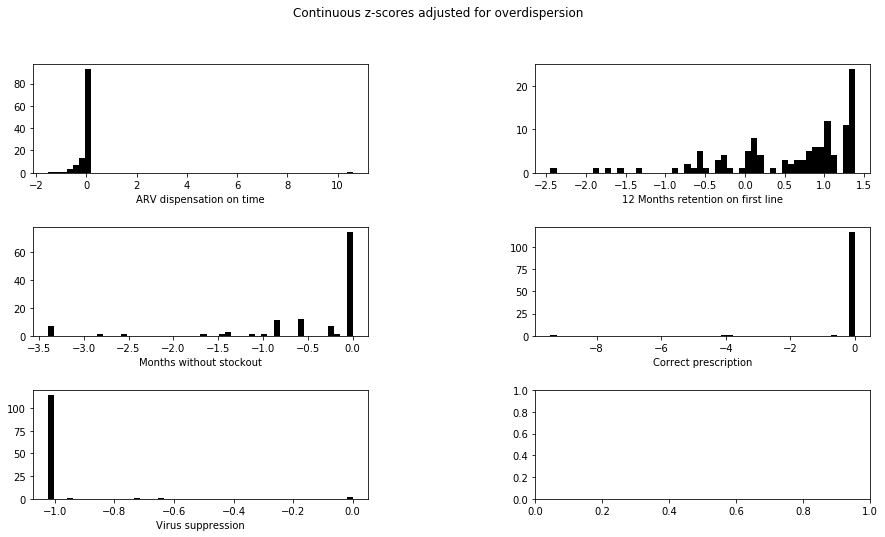

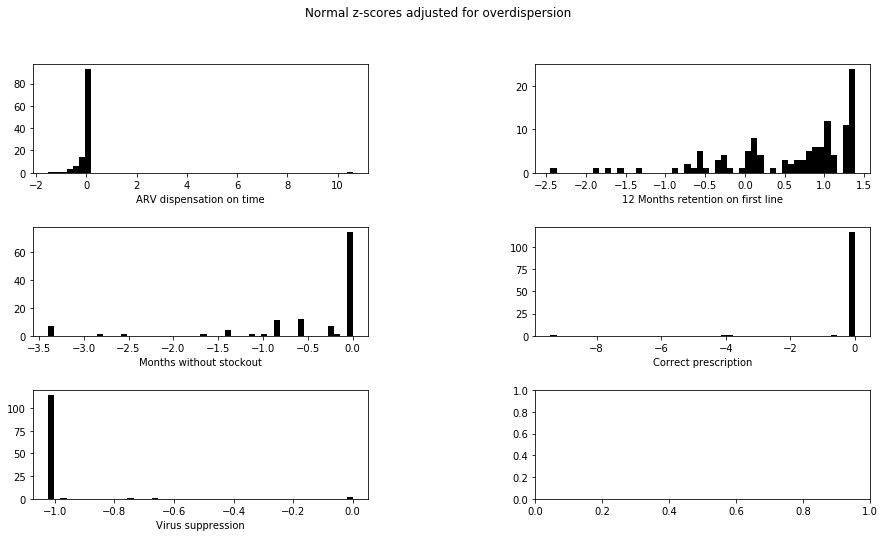

In [14]:
def plot_zs(zscores, clean_pattern, title):
    fig,axes = plt.subplots(3,2,sharex=False,sharey=False, figsize=(15, 8))
    col = 0
    row = 0
    for i in range(len(zscores.columns)):
        var = zscores.columns[i]
        var_name = var.replace(clean_pattern,"")
        n_row = int(np.floor(i/2))        
        if n_row > row:
            col = 0
            row = n_row
        axes[row,col].hist(zscores[var],bins=50,color='k')
        axes[row,col].set_xlabel(var_name)
        col = col + 1
    plt.subplots_adjust(wspace=.5,hspace=.5)
    plt.suptitle(title)
    
plot_zs(corrected_scores_continuous, "score_continuous_", "Continuous z-scores adjusted for overdispersion")
plot_zs(corrected_scores_norm, "score_normal_", "Normal z-scores adjusted for overdispersion")

We see that the z-scores obtained with the two different methods are really close. Therefore, as the normality assumption is hard to maintain, we only keep the continuous z-scores in the following work. 

We can also see that the EWIs on correct prescription and Virus suppression do not have a lot of variation. Therefore we don't think they will be very discriminant in our analysis or model.

We also look at the correlation between the different EWIs (see below). We see there is very little correlation between the different EWIs. This is not surprising because different EWI tend to look into different elements, and are therefore weakly related to each other. Meanwhile, the information we can get from this lack of correlation is that we have no reason to think that Health Facilities in which some EWI related element is out of control have overall weaker profiles than other facilities.

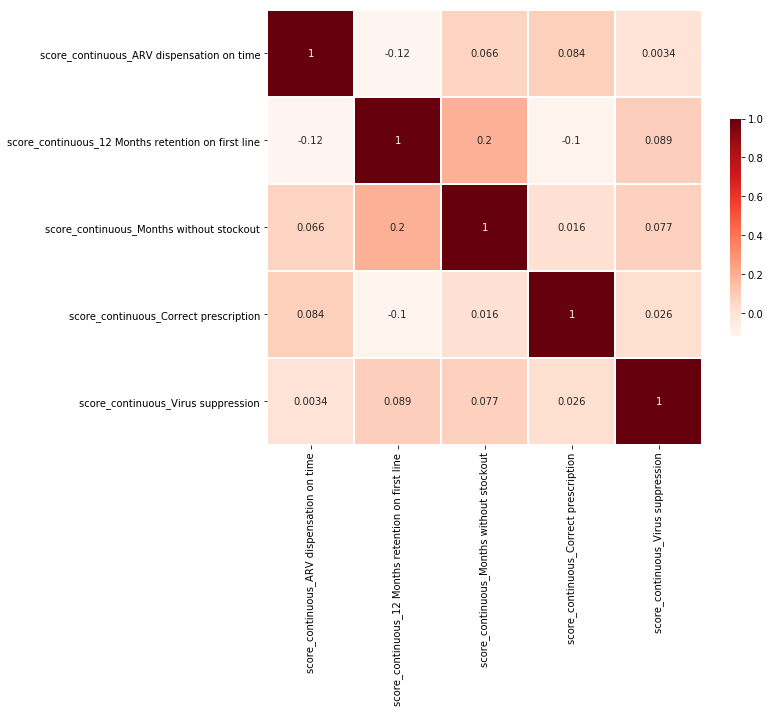

In [15]:
f, ax = plt.subplots(figsize=(10, 8))
corr = corrected_scores_continuous.corr()
sns.heatmap(corr, cmap= "Reds", square=True, ax=ax, linewidths=.5, cbar_kws={"shrink": .5} , annot=True)

Finally, to get a unique outcome variable for the EWI, we want to combine the different data EWI into a synthetic risk metric. We do so by wheighting each of the EWIs by the overall importance of its variance compared to other EWIs. 

In [16]:
# Computing the inverse of the sum of the correlation coefficients for each EWI
w = []
for col in corr.columns:
    w.append(1/sum(corr[col]))
    
# Getting a standardized combined correlation weight
denom = 0
for i in range(len(w)):
    for j in range(len(w)):
        denom = denom + corr.iloc[i,j]*w[i]*w[j]

In [17]:
# Computing a combined deviation by FOSA

corrected_scores_continuous = corrected_scores_continuous.reset_index(drop= True)
weighted_zscores = pd.DataFrame()
for j in range(len(corrected_scores_continuous.columns)):
    col_j = corrected_scores_continuous.columns[j]
    weighted_zscores[col_j] = w[j]*corrected_scores_continuous[col_j]
    
numerator = []
for i in range(len(weighted_zscores)):
    numerator.append(np.nansum(weighted_zscores.iloc[i,1:6]))
    
# Standardizing
agg_zscore = numerator/np.sqrt(denom)

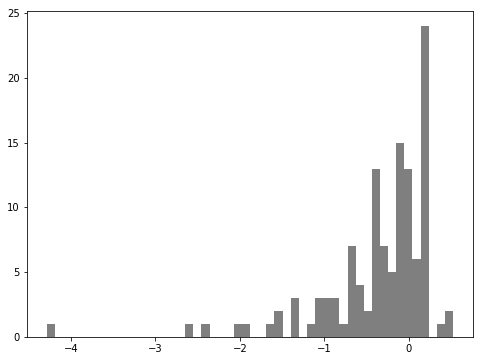

In [18]:
# Looking at the result
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1,1,1)
ax1.hist(agg_zscore,bins=50,color='k',alpha=0.5) ;

The result of the consrtruction of this variable gives an evaluation of a synthetic risk of resistande for a given FOSA. The lower the variable, the higher the deviation of EWIs in a given FOSA, and thus the higher the risk of developing HIVDR.

We now dichotomize this variable in two categories: 
* High risk : Fosa with a score lower than -1
* Low risk : Fosas with a score higher than -1

In [19]:
iap_data_2016_score["Aggregated_zscore"] = pd.Series(agg_zscore, index = iap_data_2016_score.index)
iap_data_2016_score["Z_lessThan_1"] = pd.to_numeric(iap_data_2016_score.Aggregated_zscore < -1, errors = "coerce").astype(int)
iap_data_2016_score.Z_lessThan_1.value_counts()

0    105
1     16
Name: Z_lessThan_1, dtype: int64

Using this approach, we see that we tend to consider 13% of the health facilities as being at high risk of developing HIVDR based on EWI.

## Predicting EWI

We start by combining the covariates from HIVDR and the EWI scores.

In [20]:
iap_data_2016_score.province = iap_data_2016_score.province.str.lower()
iap_data_2016_score.fosa = iap_data_2016_score.fosa.str.lower()
model_data = covariables.merge(iap_data_2016_score)
print(len(model_data))

48


We see that we have full data and EWI results for only 48 FOSAs.

We will be fitting and testing 4 different models:
* A Logistic regression
* A simple Perceptron
* A Decision Tree classifier
* A Random Forest

For each of these models, we will run a 3 folds cross validation to test the out-of sample prediction accuracy of the models.

In [21]:
models = {
    "Logistic : " : lm.LogisticRegression(penalty="l2"),
    "Perceptron : " : lm.Perceptron(),
    "Decision Tree : " : DecisionTreeClassifier(),
    "Random Forest : " : RandomForestClassifier()
}

X = model_data[['stockout_perc', 'first_line', 'second_line', 'n_pdv', 'n_pvvih']]
y = model_data["Z_lessThan_1"]

for model in models.keys():
    print(model + str(np.mean(cross_val_score(models[model], X, y, cv=3))))

Logistic : 0.8120098039215686
Perceptron : 0.8342320261437909
Decision Tree : 0.7297385620915033
Random Forest : 0.8146241830065359


We see that we achieve the best predictivity of EWI classes using a perceptron, which has an average cross validation of 83%. For this problem, it would seem that decision trees and Random Forest underperform at their task, while linear methods seem to be more appropriate. This is coherent with the feature building work we have done, in which we have tried to build features as close as possible to the EWI themselves.